### Cài đặt và khai báo thư viện

In [3]:
pip install fake-useragent

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import time
import json
import os
import sys
import random
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from fake_useragent import UserAgent
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

### Chọn ra 10000 bài hát tiêu biểu

Vì data đã qua xử lý là 660380 bài. Rất lớn để cào thêm genre của bài hát, do đó nhóm đại diện cào 10000 bài tiêu biểu (Phân bố đều theo popularity) để cào genre(thể loại) của bài hát và tiến hành EDA dữ liệu.

In [9]:
df = pd.read_csv('../data/processed_data.csv')

In [10]:
# Tổng số bài mong muốn
total_samples = 10000

bins = range(0, 101, 10)
df['popularity_bin'] = pd.cut(df['popularity'], bins=bins, right=False)

# Tính tỷ lệ phân bổ trong từng khoảng
popularity_distribution = df['popularity_bin'].value_counts(normalize=True)
print(popularity_distribution)

# Tính tỷ lệ phân bổ và số mẫu cần lấy cho từng bin
popularity_distribution = df['popularity_bin'].value_counts(normalize=True)
popularity_distribution = popularity_distribution.sort_index()

# Số mẫu cần lấy cho từng bin
samples_per_bin = (popularity_distribution * total_samples).astype(int)

# Đảm bảo tổng số mẫu đúng bằng 10,000
remaining_samples = total_samples - samples_per_bin.sum()
if remaining_samples > 0:
    # Phân bổ số dư còn lại đều vào các bin (hoặc có thể tùy chỉnh cách phân bổ)
    extra_samples = np.zeros(len(samples_per_bin), dtype=int)
    extra_samples[:remaining_samples] = 1
    samples_per_bin += extra_samples

# Lấy mẫu theo tỷ lệ đã tính toán
eda_df = df.groupby('popularity_bin').apply(
    lambda x: x.sample(n=samples_per_bin[x.name], replace=True)
).reset_index(drop=True)

popularity_bin
[0, 10)      0.287271
[30, 40)     0.176833
[20, 30)     0.159425
[40, 50)     0.137256
[10, 20)     0.124020
[50, 60)     0.076156
[60, 70)     0.029940
[70, 80)     0.007967
[80, 90)     0.001131
[90, 100)    0.000000
Name: proportion, dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_14680\515635984.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eda_df = df.groupby('popularity_bin').apply(
C:\Users\DELL\AppData\Local\Temp\ipykernel_14680\515635984.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eda_df = df.groupby('popularity_bin').apply(


In [11]:
eda_df.drop(columns=['popularity_bin'], inplace=True)

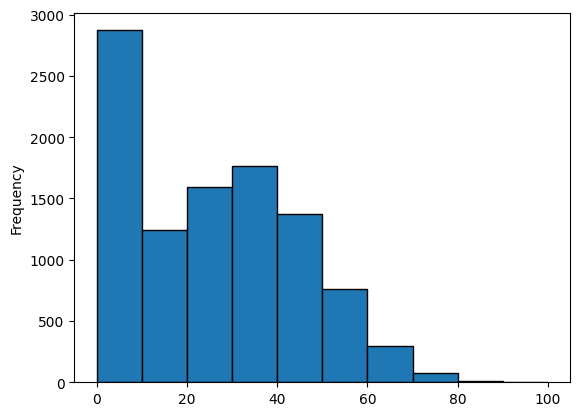

In [12]:
# Kiểm pha phân bố popularity bằng biểu đồ
import matplotlib.pyplot as plt

eda_df['popularity'].plot.hist(bins=bins, edgecolor='black')
plt.show()

In [ ]:
eda_df.to_csv('../data/eda_data_withoutgeniusID.csv', index=False)

### Sau khi chọn ra 10000 bài hát tiêu biểu, ta dùng API itunes.apple để lấy genre(thể loại) của nhạc. Do phần này nhóm cào trên kaggle nên chỉ copy code lại chứ không chạy ra output.

#### Cào 5000 bài đầu tiên

In [ ]:
eda_df = pd.read_csv('/kaggle/input/eda-data-test/eda_data_withoutgeniusID.csv')

In [15]:
eda_df_first = eda_df[:5000]
eda_df_first

,track_name,track_id,track_uri,artist_name,album_name,album_uri,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,popularity,release_date
0,Creature,56LGS7W4ji1xq7kVwZLGKm,spotify:track:56LGS7W4ji1xq7kVwZLGKm,Asking Alexandria,From Death To Destiny,spotify:album:3yPGBS6p3GyFb9EySzFyYi,0.476,0.940,4,-3.720,...,0.000088,0.000255,0.1120,0.461,75.990,spotify:track:56LGS7W4ji1xq7kVwZLGKm,194210,4,0,2013-08
1,Saviour (feat. First Aid Kit),1bqziTtf2GPj47mlktYSCp,spotify:track:1bqziTtf2GPj47mlktYSCp,George Ezra,Saviour (feat. First Aid Kit),spotify:album:06W3DE8Zd3CfyO78Nrxqzu,0.582,0.783,7,-6.437,...,0.050500,0.000016,0.2440,0.187,101.009,spotify:track:1bqziTtf2GPj47mlktYSCp,212274,4,0,2018-03
2,You Don't Know,2BlM00LsKY0pFKEChrQa9Y,spotify:track:2BlM00LsKY0pFKEChrQa9Y,Katelyn Tarver,Tired Eyes,spotify:album:7sj87mBaofDr9oJ0C22yFg,0.560,0.315,10,-8.532,...,0.734000,0.000001,0.1050,0.138,78.060,spotify:track:2BlM00LsKY0pFKEChrQa9Y,260851,4,0,2017-03
3,Indoor Kid,2yZIRU8wustsH9QN9qytlM,spotify:track:2yZIRU8wustsH9QN9qytlM,Sløtface,AWAKE/ASLEEP,spotify:album:2SM92RVNoh8JWPf4cSc6iy,0.817,0.615,0,-9.776,...,0.201000,0.000012,0.1240,0.570,127.926,spotify:track:2yZIRU8wustsH9QN9qytlM,170625,4,7,2023-02
4,Copper & Hippie,0lCeHDLulLEJLpZBO89pAK,spotify:track:0lCeHDLulLEJLpZBO89pAK,康姆士(COM’Z),康姆士（COM'Z）,spotify:album:668I5aWYJ4Rz5JAdKHxiZo,0.637,0.640,6,-3.651,...,0.285000,0.000000,0.0945,0.386,110.003,spotify:track:0lCeHDLulLEJLpZBO89pAK,273640,4,1,2014-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Let the Music Play,6MiBNNFetK40dpAXaBOizm,spotify:track:6MiBNNFetK40dpAXaBOizm,Stick Figure,The Reprise Sessions,spotify:album:4UEVPHw9aIh2hc0fqbS9pN,0.782,0.627,10,-6.996,...,0.016300,0.487000,0.0935,0.848,137.963,spotify:track:6MiBNNFetK40dpAXaBOizm,279960,4,27,2010-08
4996,Here we go,0BycSgjwTyMj3qKR9D9XqV,spotify:track:0BycSgjwTyMj3qKR9D9XqV,Lij9,Here we go,spotify:album:0vO2lgY2V5X72AfVrjOzH6,0.387,0.525,10,-12.425,...,0.098200,0.000000,0.1420,0.262,180.252,spotify:track:0BycSgjwTyMj3qKR9D9XqV,106736,4,22,2024-07
4997,Don't Like Me,4EgRVE9vfxlNgjG6fNpBuL,spotify:track:4EgRVE9vfxlNgjG6fNpBuL,Chris Travis,Water World 2,spotify:album:27uJCAFag37CgoMd5Asj1F,0.893,0.632,8,-8.410,...,0.169000,0.000002,0.0546,0.571,140.098,spotify:track:4EgRVE9vfxlNgjG6fNpBuL,102752,4,27,2024-10
4998,"My Jesus, I Love Thee",5Ws9Mkn4ClkjMllKVAvkCJ,spotify:track:5Ws9Mkn4ClkjMllKVAvkCJ,Casting Crowns,Glorious Day: Hymns of Faith,spotify:album:3hB7IALT7uaNMC6Ol0elbo,0.241,0.353,1,-10.863,...,0.812000,0.001140,0.0979,0.123,94.180,spotify:track:5Ws9Mkn4ClkjMllKVAvkCJ,271786,4,29,2015-07


In [16]:
user_agents = UserAgent()

In [17]:
def get_genre_with_header(song, artist):
    url = "https://itunes.apple.com/search"
    params = {"term": f"{song} {artist}", "entity": "song", "limit": 1}
    headers = {"User-Agent": user_agents.random}  # Randomized User-Agent
    
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=2, status_forcelist=[429, 500, 502, 503, 504])
    session.mount('https://', HTTPAdapter(max_retries=retries))
    
    try:
        response = session.get(url, params=params, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if data.get("resultCount", 0) > 0:
                return data["results"][0].get("primaryGenreName", "")
            return "Not Found"
        else:
            print(f"API error {response.status_code}: {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    return "Error"

In [ ]:
genres = []
for i, (song, artist) in enumerate(zip(eda_df_first['track_name'], eda_df_first['artist_name'])):
    genre = get_genre_with_header(song, artist)
    genres.append(genre)
    print(i, genre)

    time.sleep(random.uniform(0.8, 1.5))  

    if i > 0 and i % 30 == 0:
        print("Taking a longer break...")
        time.sleep(random.uniform(15, 25))  

In [ ]:
eda_df_first['genre'] = genres

In [ ]:
eda_df_first.to_csv('/kaggle/working/tags_0_5000.csv', index=False)

#### Cào 5000 bài sau

In [18]:
eda_df = pd.read_csv('/kaggle/input/eda-data-test/eda_data_withoutgeniusID.csv')

In [19]:
eda_df_last = eda_df[5000:]
eda_df_last

,track_name,track_id,track_uri,artist_name,album_name,album_uri,danceability,energy,key,loudness,...,acousticness,instrumentalness,liveness,valence,tempo,uri,duration_ms,time_signature,popularity,release_date
5000,Come On In My Kitchen,7wmX9k2kWK3PrfBbTgOzZV,spotify:track:7wmX9k2kWK3PrfBbTgOzZV,Crooked Still,Shaken By A Low Sound,spotify:album:1MXfI5PVHDjkZJrlM9aFkp,0.629,0.218,6,-12.951,...,0.7100,0.123000,0.1030,0.235,142.736,spotify:track:7wmX9k2kWK3PrfBbTgOzZV,299213,4,28,2006-08
5001,Infiltrate,5n71qHTwWmbYopWjTXuU3z,spotify:track:5n71qHTwWmbYopWjTXuU3z,Phlocalyst,Breakup,spotify:album:78A7EqSU92xHDKZy3JzJ8c,0.665,0.249,1,-12.285,...,0.3160,0.926000,0.1260,0.177,82.009,spotify:track:5n71qHTwWmbYopWjTXuU3z,143446,4,29,2024-08
5002,Vana,6r5Cyh4URoP8SnzgYwe4LP,spotify:track:6r5Cyh4URoP8SnzgYwe4LP,Vitico Flow,Vibe Cycle,spotify:album:38JT8w7YlH8HlJC5uzdf3O,0.669,0.795,2,-11.000,...,0.1310,0.813000,0.1370,0.325,126.098,spotify:track:6r5Cyh4URoP8SnzgYwe4LP,137038,4,23,2024-05
5003,Lose Your Love (Dirty Projectors x Chromeo) - ...,6VLQWIRjq7UjmTaN3ra51Q,spotify:track:6VLQWIRjq7UjmTaN3ra51Q,Dirty Projectors,Lose Your Love (Dirty Projectors x Chromeo) [C...,spotify:album:6Y6YeVV1awYIyWDl8afa0f,0.835,0.785,8,-4.575,...,0.0988,0.000192,0.1190,0.847,118.002,spotify:track:6VLQWIRjq7UjmTaN3ra51Q,222875,4,20,2020-10
5004,When I Wake Up,6TYaTUkuerVnw7neS9bpsY,spotify:track:6TYaTUkuerVnw7neS9bpsY,Iggy,When I Wake Up,spotify:album:4q0YaMUZW9at7ItLHFcB7c,0.663,0.628,5,-8.583,...,0.4540,0.003360,0.0910,0.281,119.992,spotify:track:6TYaTUkuerVnw7neS9bpsY,175266,4,26,2016-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,PUSH 2 START,1Cbl3Yq8rHo7hhDQmLQagU,spotify:track:1Cbl3Yq8rHo7hhDQmLQagU,Tyla,TYLA +,spotify:album:5QsVRNOKVMCeVAIUoOQJ13,0.683,0.814,2,-3.505,...,0.2770,0.008260,0.0858,0.758,93.482,spotify:track:1Cbl3Yq8rHo7hhDQmLQagU,156825,4,81,2024-10
9996,MILLION DOLLAR BABY,5AJ9hqTS2wcFQCELCFRO7A,spotify:track:5AJ9hqTS2wcFQCELCFRO7A,Tommy Richman,MILLION DOLLAR BABY,spotify:album:2Z1gnUf3nbn6DtwZSUIH54,0.852,0.697,1,-5.520,...,0.0973,0.000370,0.0678,0.919,138.029,spotify:track:5AJ9hqTS2wcFQCELCFRO7A,155151,4,88,2024-04
9997,Slow It Down,51eSHglvG1RJXtL3qI5trr,spotify:track:51eSHglvG1RJXtL3qI5trr,Benson Boone,Fireworks & Rollerblades,spotify:album:168CdR21lfn0TTyw1Pkdcm,0.432,0.583,8,-4.682,...,0.1740,0.000000,0.0933,0.544,181.489,spotify:track:51eSHglvG1RJXtL3qI5trr,161831,4,85,2024-04
9998,"Paint It, Black",63T7DJ1AFDD6Bn8VzG6JE8,spotify:track:63T7DJ1AFDD6Bn8VzG6JE8,The Rolling Stones,Aftermath,spotify:album:72qrnM4yUNMDDlWiqKc8iY,0.464,0.795,1,-9.267,...,0.0493,0.002440,0.3990,0.612,158.691,spotify:track:63T7DJ1AFDD6Bn8VzG6JE8,202266,4,81,1966-04


In [ ]:
user_agents = UserAgent()

In [ ]:
def get_genre_with_header(song, artist):
    url = "https://itunes.apple.com/search"
    params = {"term": f"{song} {artist}", "entity": "song", "limit": 1}
    headers = {"User-Agent": user_agents.random}  # Randomized User-Agent
    
    session = requests.Session()
    retries = Retry(total=5, backoff_factor=2, status_forcelist=[429, 500, 502, 503, 504])
    session.mount('https://', HTTPAdapter(max_retries=retries))
    
    try:
        response = session.get(url, params=params, headers=headers)
        if response.status_code == 200:
            data = response.json()
            if data.get("resultCount", 0) > 0:
                return data["results"][0].get("primaryGenreName", "")
            return "Not Found"
        else:
            print(f"API error {response.status_code}: {response.text}")
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    return "Error"

In [ ]:
genres = []
for i, (song, artist) in enumerate(zip(eda_df_last['track_name'], eda_df_last['artist_name'])):
    genre = get_genre_with_header(song, artist)
    genres.append(genre)
    print(i, genre)

    time.sleep(random.uniform(0.8, 1.5))  

    if i > 0 and i % 30 == 0:
        print("Taking a longer break...")
        time.sleep(random.uniform(15, 25))  

In [ ]:
eda_df_last['genre'] = genres

In [ ]:
eda_df_first.to_csv('/kaggle/working/tags_5000_10000.csv', index=False)